# A small-scale version of our pipeline

### Imports

In [2]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

### Loading the dataset

In [3]:
import pandas as pd
import regex as re
from cleantext import clean
raw_data = pd.read_csv("data/sample_preprocessed_ver_", index_col=0)

In [4]:
raw_data = raw_data.sample(frac=0.1, random_state=0)

In [5]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)
raw_data['content'] = raw_data['content'].apply(string_to_list)

In [6]:
len(raw_data)

311

In [7]:
def fix_labels(df): 
    df.type = df.type.replace({'political': 'reliable', 'junksci': 'fake', 'bias' : 'fake', 'satire': 'fake', 'conspiracy': 'fake', 'rumor': 'fake', 'unreliable' : 'fake', 'clickbait': 'fake', 'hate': 'fake'})
    df = df[df.type != 'unknown']
    df = df[df.type != 'type']
    df = df[df.type.notnull()]
    return df

In [8]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [9]:
data = fix_labels(raw_data)

In [10]:
print(labelperc(data))

{'reliable': 49.51768488745981, 'fake': 50.482315112540185}


In [11]:
data.head()

,level_0,index,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
2717,3504,1299,9030358,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"[hirsh, barbara, vigdor, belov, wife, late, wa...",2018-02-11 00:41:26.676418,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Paid Notice: Deaths HIRSH, BARBARA VIGDOR",NaN,NaN,['HIRSH BARBARA VIGDOR'],HIRSH--Barbara Vigdor. Beloved wife of the lat...,NaN,NaN,nytimes
849,1170,6686,2995926,express.co.uk,fake,https://www.express.co.uk/sport/football/86665...,"[manchest, unit, boss, jose, mourinho, face, w...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Jose Mourinho: Liverpool fans slam 'embarrassi...,Michael Potts,NaN,[''],JOSE MOURINHO has sparked a Liverpool meltdown...,NaN,NaN,NaN
2662,3449,4202,8913261,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"[editor, url, chicken, dinner, els, beef, horm...",2018-02-11 00:40:14.285474,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Eat at Your Own Risk,NaN,NaN,"['Food Contamination and Poisoning', 'Poultry'...","<br>To the Editor:\n<p>\n O.K., no chicken fo...",NaN,NaN,nytimes
224,289,8490,748126,dailykos.com,reliable,https://www.dailykos.com/stories/2010/03/21/84...,"[doubter, predict, scandal, gave, success, sto...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Barack Obama, On The Cusp Of History... Again","Backgroundurl Avatar_Large, Nickname, Joined, ...",NaN,[''],NaN,NaN,NaN,NaN
553,790,1350,2037805,dailykos.com,reliable,https://www.dailykos.com/stories/2005/11/17/16...,"[guess, yet, pleas, say, steroid, url, pleas, ...",2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Congress To Focus on REAL Problems Affecting S...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",NaN,[''],NaN,NaN,NaN,NaN


### Simple Model - Logistic Regression

In [55]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [56]:
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=100000, vocabulary=set(words.words()))
vectorizer.fit(X_train)

c:\Users\Kaest\miniconda3\envs\FakeNews\lib\site-packages\sklearn\feature_extraction\text.py:1379: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


CountVectorizer(analyzer=<function <lambda> at 0x000001FAB44829E0>,
                max_features=100000,
                vocabulary={'A', 'Aani', 'Aaron', 'Aaronic', 'Aaronical',
                            'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'Ababdeh',
                            'Ababua', 'Abadite', 'Abama', 'Abanic', 'Abantes',
                            'Abarambo', 'Abaris', 'Abasgi', 'Abassin', 'Abatua',
                            'Abba', 'Abbadide', 'Abbasside', 'Abbie', 'Abby',
                            'Abderian', 'Abderite', 'Abdiel', 'Abdominales',
                            'Abe', ...})

In [57]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [58]:
X_train.shape

(248, 235892)

In [59]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [60]:
pred = model.predict(X_val)

In [61]:
accuracy_score(y_val, pred)

0.7096774193548387

f1 score:

In [62]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable. False positive skal være det værste, 
# så når vi kalder en fake artikel reliable, så falder der brænde.
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.6666666666666666

Confusion matrix

In [63]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)

[[13  7]
 [ 2  9]]


plotting

<Axes: >

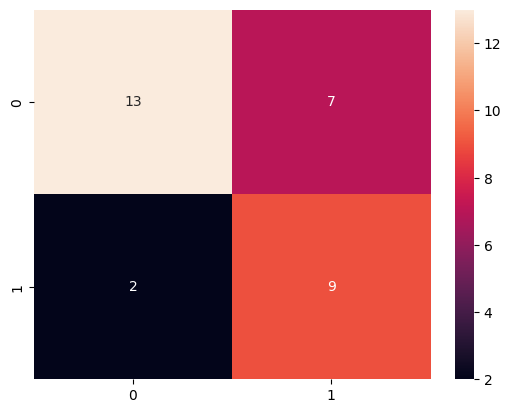

In [64]:
import seaborn as sns
# plotting to a heatmap
sns.heatmap(cf_matrix, annot=True)

### Simple Model - Naive Bayes

In [65]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val_raw, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, vocabulary=set(words.words()))
vectorizer.fit(X_train)

c:\Users\Kaest\miniconda3\envs\FakeNews\lib\site-packages\sklearn\feature_extraction\text.py:1379: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


CountVectorizer(analyzer=<function <lambda> at 0x000001FAB4656200>,
                vocabulary={'A', 'Aani', 'Aaron', 'Aaronic', 'Aaronical',
                            'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'Ababdeh',
                            'Ababua', 'Abadite', 'Abama', 'Abanic', 'Abantes',
                            'Abarambo', 'Abaris', 'Abasgi', 'Abassin', 'Abatua',
                            'Abba', 'Abbadide', 'Abbasside', 'Abbie', 'Abby',
                            'Abderian', 'Abderite', 'Abdiel', 'Abdominales',
                            'Abe', ...})

In [67]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val_raw)
X_test = vectorizer.transform(X_test)

In [68]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [69]:
pred_val = model.predict(X_val)

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred_val)

0.6774193548387096

Finding the f1 score

In [71]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable. False positive skal være det værste, 
# så når vi kalder en fake artikel reliable, så falder der brænde.
f1_score(pd.Series.to_numpy(y_val), pred_val, pos_label='reliable')

0.6875000000000001

Confusion matrix

In [72]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred_val)
print(cf_matrix)

[[10 10]
 [ 0 11]]


Plottring

<Axes: >

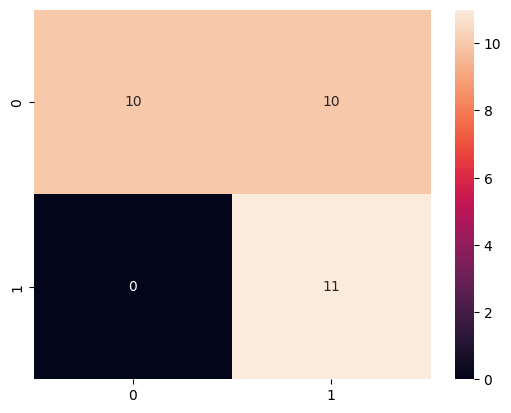

In [73]:
import seaborn as sns
# plotting to a heatmap
sns.heatmap(cf_matrix, annot=True)

# Heatmap over most frequent words. One with reliable tag, and one with fake

In [74]:
print(type(X_val))
# toarray to get it to plot, but i need to first only get fakes, and reliables...
print(len(X_val.toarray()))
print(len(X_test.toarray()))

<class 'scipy.sparse._csr.csr_matrix'>
31
32


In [89]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
#cf_matrix = confusion_matrix(X_val.toarray(), X_test.toarray())
#print(cf_matrix)

print(type(X_val))
print(vectorizer.get_feature_names_out()[0:10])
print(X_val.toarray()[0:10])

<class 'scipy.sparse._csr.csr_matrix'>
['A' 'Aani' 'Aaron' 'Aaronic' 'Aaronical' 'Aaronite' 'Aaronitic' 'Aaru'
 'Ab' 'Ababdeh']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
